# Audio feature extraction

In this lab, we will practice audio feature extraction with `torchaudio` and `librosa`

`torchaudio` implements feature extractions commonly used in the audio domain. They are available in `torchaudio.functional` and `torchaudio.transforms`.

To install required packages in this lab, run:
```bash
pip install requirements.txt
```

## Import library

In [15]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
from IPython.display import Audio

print(torch.__version__)
print(torchaudio.__version__)

import librosa
import matplotlib.pyplot as plt

2.4.0+cu121
2.4.0+cu121


In [5]:
def plot_waveform(waveform, sr, title="Waveform", ax=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    if ax is None:
        _, ax = plt.subplots(num_channels, 1)
    ax.plot(time_axis, waveform[0], linewidth=1)
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)


def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")


def plot_fbank(fbank, title=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Filter bank")
    axs.imshow(fbank, aspect="auto")
    axs.set_ylabel("frequency bin")
    axs.set_xlabel("mel bin")

In [9]:
import IPython.display as ipd

# Load audio file
audio_path = './test.wav'
data, sampling_rate = torchaudio.load(audio_path)
print(data)
# Play audio
ipd.Audio(data, rate=sampling_rate)

tensor([[-7.3242e-04, -7.6294e-04, -6.4087e-04,  ...,  7.3242e-04,
          2.1362e-04,  6.1035e-05]])


## Spectrogram

In [10]:
# Define transform
spectrogram = T.Spectrogram(n_fft=512)

# Perform transform
spec = spectrogram(data)

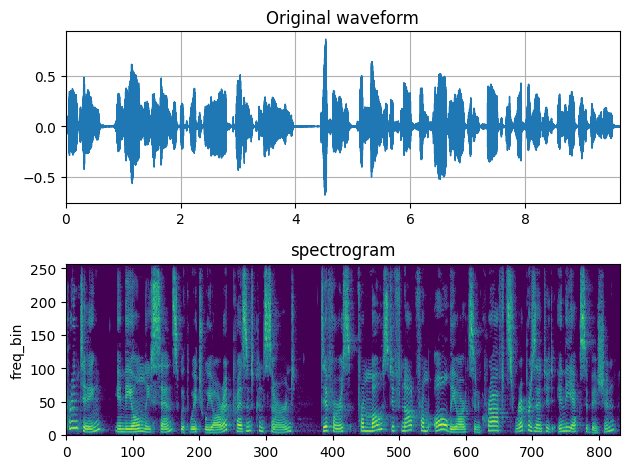

In [11]:
fig, axs = plt.subplots(2, 1)
plot_waveform(data, sampling_rate, title="Original waveform", ax=axs[0])
plot_spectrogram(spec[0], title="spectrogram", ax=axs[1])
fig.tight_layout()

//TODO: more about n_fft

## GriffinLim

To recover a waveform from a spectrogram, you can use `torchaudio.transforms.GriffinLim`

The same set of parameters used for spectrogram must be used.

In [13]:
# Define transforms
n_fft = 1024
spectrogram = T.Spectrogram(n_fft=n_fft)
griffin_lim = T.GriffinLim(n_fft=n_fft)

# Apply the transforms
spec = spectrogram(data)
reconstructed_waveform = griffin_lim(spec)

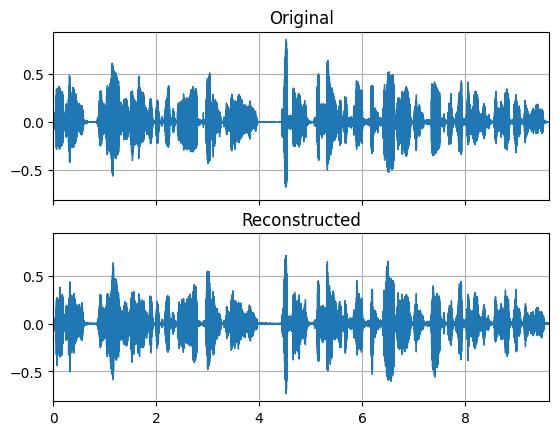

In [16]:
_, axes = plt.subplots(2, 1, sharex=True, sharey=True)
plot_waveform(data, sampling_rate, title="Original", ax=axes[0])
plot_waveform(reconstructed_waveform, sampling_rate, title="Reconstructed", ax=axes[1])
Audio(reconstructed_waveform, rate=sampling_rate)

## Mel Filter Bank
torchaudio.functional.melscale_fbanks() generates the filter bank for converting frequency bins to mel-scale bins.

Since this function does not require input audio/features, there is no equivalent transform in torchaudio.transforms().

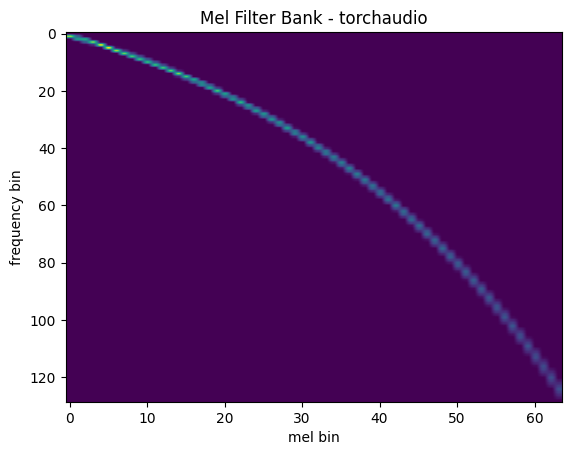

In [17]:
n_fft = 256
n_mels = 64
sample_rate = 6000

mel_filters = F.melscale_fbanks(
    int(n_fft // 2 + 1),
    n_mels=n_mels,
    f_min=0.0,
    f_max=sample_rate / 2.0,
    sample_rate=sample_rate,
    norm="slaney",
)
plot_fbank(mel_filters, "Mel Filter Bank - torchaudio")

# MelSpectrogram

Generating a mel-scale spectrogram involves generating a spectrogram and performing mel-scale conversion. In torchaudio, torchaudio.transforms.MelSpectrogram() provides this functionality.

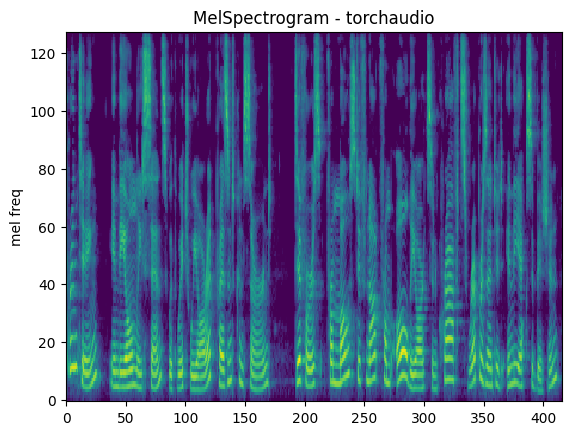

In [18]:
n_fft = 1024
win_length = None
hop_length = 512
n_mels = 128

mel_spectrogram = T.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    norm="slaney",
    n_mels=n_mels,
    mel_scale="htk",
)

melspec = mel_spectrogram(data)
plot_spectrogram(melspec[0], title="MelSpectrogram - torchaudio", ylabel="mel freq")

# MFCC

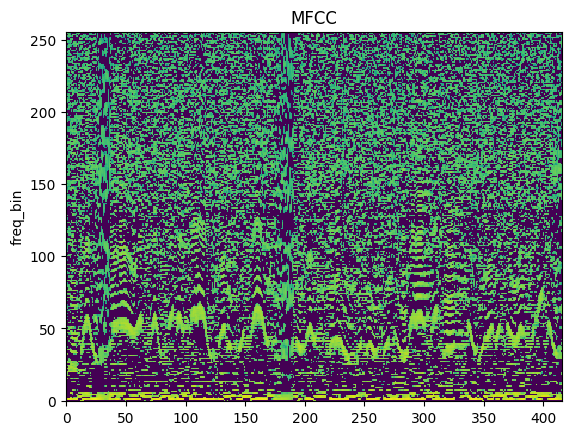

In [19]:
n_fft = 2048
win_length = None
hop_length = 512
n_mels = 256
n_mfcc = 256

mfcc_transform = T.MFCC(
    sample_rate=sample_rate,
    n_mfcc=n_mfcc,
    melkwargs={
        "n_fft": n_fft,
        "n_mels": n_mels,
        "hop_length": hop_length,
        "mel_scale": "htk",
    },
)

mfcc = mfcc_transform(data)
plot_spectrogram(mfcc[0], title="MFCC")

# LFCC

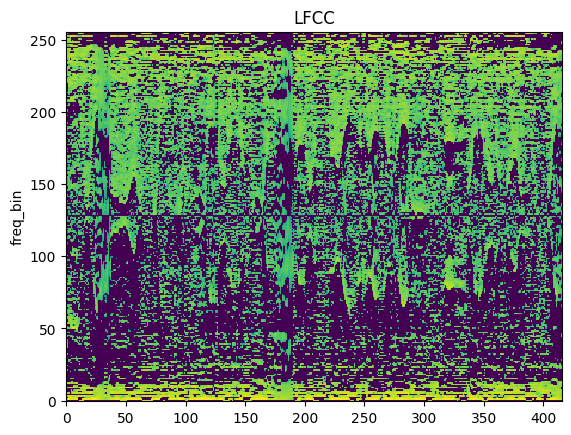

In [20]:
n_fft = 2048
win_length = None
hop_length = 512
n_lfcc = 256

lfcc_transform = T.LFCC(
    sample_rate=sample_rate,
    n_lfcc=n_lfcc,
    speckwargs={
        "n_fft": n_fft,
        "win_length": win_length,
        "hop_length": hop_length,
    },
)

lfcc = lfcc_transform(data)
plot_spectrogram(lfcc[0], title="LFCC")

# Pitch

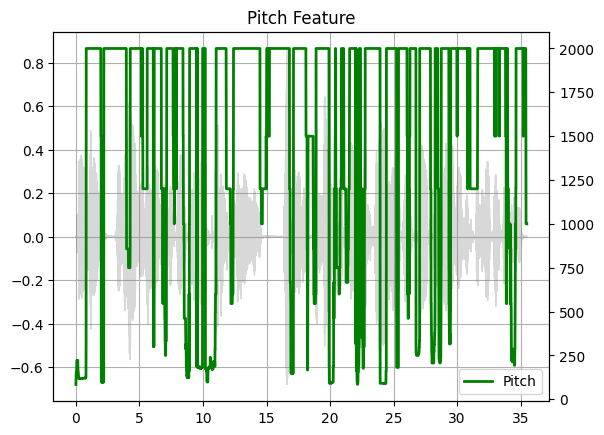

In [21]:
pitch = F.detect_pitch_frequency(data, sample_rate)
def plot_pitch(waveform, sr, pitch):
    figure, axis = plt.subplots(1, 1)
    axis.set_title("Pitch Feature")
    axis.grid(True)

    end_time = waveform.shape[1] / sr
    time_axis = torch.linspace(0, end_time, waveform.shape[1])
    axis.plot(time_axis, waveform[0], linewidth=1, color="gray", alpha=0.3)

    axis2 = axis.twinx()
    time_axis = torch.linspace(0, end_time, pitch.shape[1])
    axis2.plot(time_axis, pitch[0], linewidth=2, label="Pitch", color="green")

    axis2.legend(loc=0)


plot_pitch(data, sample_rate, pitch)